# Trist'n Joseph - IST 718 - Lab 2 (Forecasting)

## Packages

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from math import sqrt

import warnings

In [2]:
zwillow_median_train_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST718/Labs/Lab 2/zwillow_Median_training_data.csv"
zwillow_median_test_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST718/Labs/Lab 2/zwillow_Median_testing_data.csv"

zwillow_train = pd.read_csv(zwillow_median_train_path)
zwillow_test = pd.read_csv(zwillow_median_test_path)

zwillow_train['Date'] = zwillow_train['Date'].astype('datetime64[ns]')
zwillow_test['Date'] = zwillow_test['Date'].astype('datetime64[ns]')

In [3]:
final_training_index = len(zwillow_train)
new_testing_indexes = []
for i in range(0, len(zwillow_test)):
    new_index = final_training_index + i
    new_testing_indexes.append(new_index)
    
zwillow_test['new_index'] = new_testing_indexes
zwillow_test.set_index('new_index', inplace=True)

## Forecasting

Because the data is non-stationary (from `EDA`), differencing is required.

In [4]:
def test_stationarity(timeseries):
         
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [5]:
def difference(timeseries, interval):
    
    differences = []
    for i in range(1, len(timeseries)):
        difference = timeseries[i] - timeseries[i - interval]
        differences.append(difference)
        
    return differences

In [6]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [7]:
FirstDiff = difference(zwillow_train.HousingValue, 1)
zwillow_train_FirstDiff = zwillow_train.iloc[1: , :]
zwillow_train_FirstDiff['HousingValueFirstDifference'] = FirstDiff
zwillow_train_FirstDiff.drop(['Dates', 'HousingValue', 'Date'], 1, inplace=True)

<ipython-input-7-9df75cdf4686>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zwillow_train_FirstDiff['HousingValueFirstDifference'] = FirstDiff
C:\Users\trist\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
test_stationarity(zwillow_train_FirstDiff)

Results of Dickey-Fuller Test:
Test Statistic                  -4.964819
p-value                          0.000026
# Lags Used                      3.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


The null hypothesis of DF test suggests that the data series is not stationary.

With a p-value of `0.000026`, there is enough evidence at the 5% level of significance to reject the null hypothesis. Therefore, it is likely that the data series is stationary.

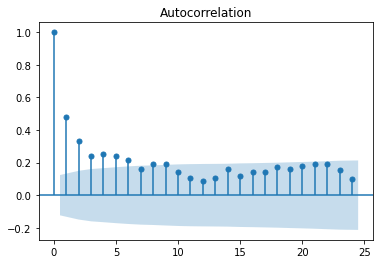

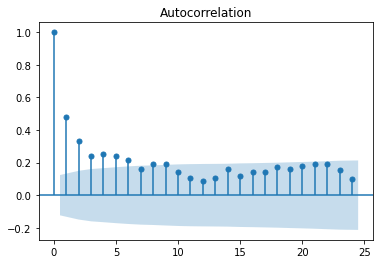

In [9]:
plot_acf(zwillow_train_FirstDiff)

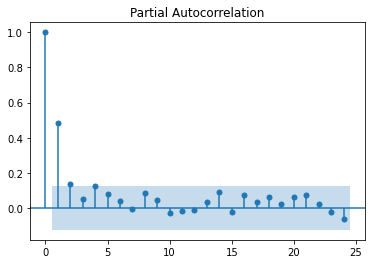

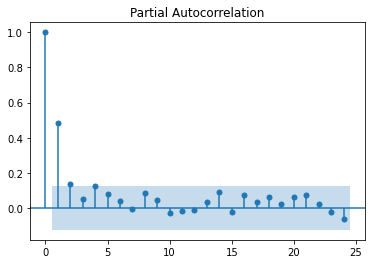

In [10]:
plot_pacf(zwillow_train_FirstDiff)

### ARIMA(1, 1, 1)

In [11]:
def calculate_model_accuracy(actual, forecast):
    rmse = round(np.mean((forecast - actual)**2)**.5, 4)
    
    print('The RMSE for this model is ~{0}'.format(rmse))
    return rmse

In [12]:
# using ARIMA(p, d, q)
# -- let p=1, d=1, q=1
arima_model_111 = ARIMA(zwillow_train.HousingValue, order=(1, 1, 1))
arima_model_111_results = arima_model_111.fit(maxiter=500)  
print(arima_model_111_results.summary())

C:\Users\trist\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.HousingValue   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1890.079
Method:                       css-mle   S.D. of innovations            450.609
Date:                Mon, 08 Nov 2021   AIC                           3788.159
Time:                        00:31:54   BIC                           3802.261
Sample:                             1   HQIC                          3793.834
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  177.4070     72.662      2.442      0.015      34.991     319.823
ar.L1.D.HousingValue     0.7681      0.099      7.764      0.000       0.574       0.962
ma.L1.D.Hous

C:\Users\trist\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<Figure size 144000x3600 with 0 Axes>

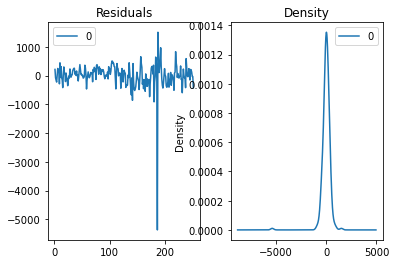

In [13]:
arima_model_111_residuals = pd.DataFrame(arima_model_111_results.resid)

fig = plt.figure(figsize = (2000, 50))
fig, ax = plt.subplots(1, 2)
arima_model_111_residuals.plot(title="Residuals", ax=ax[0])
arima_model_111_residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [14]:
arima_model_111_forecast, arima_model_111_se, arima_model_111_conf_interval = arima_model_111_results.forecast(27, alpha=0.05)
arima_model_111_forecast_series = pd.Series(arima_model_111_forecast, index=zwillow_test.HousingValue.index)
arima_model_111_conf_interval_lower = pd.Series(arima_model_111_conf_interval[:, 0], index=zwillow_test.HousingValue.index)
arima_model_111_conf_interval_upper = pd.Series(arima_model_111_conf_interval[:, 1], index=zwillow_test.HousingValue.index)

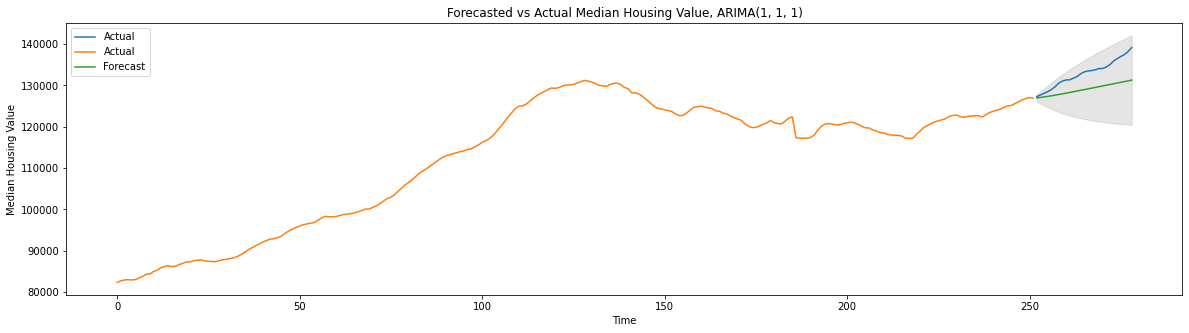

In [15]:
fig = plt.figure(figsize = (20, 5))
plt.plot(zwillow_test.HousingValue, label='Actual')
plt.plot(zwillow_train.HousingValue, label='Actual')
plt.plot(arima_model_111_forecast_series, label='Forecast')
plt.fill_between(arima_model_111_conf_interval_lower.index, arima_model_111_conf_interval_lower, arima_model_111_conf_interval_upper, color='k', alpha=0.10)
plt.xlabel('Time')
plt.ylabel('Median Housing Value')
plt.title('Forecasted vs Actual Median Housing Value, ARIMA(1, 1, 1)')
plt.legend()
plt.show()

In [16]:
calculate_model_accuracy(zwillow_test.HousingValue, arima_model_111_forecast_series)

The RMSE for this model is ~4289.9196


4289.9196

### Searching For Optimal ARIMA Parameters

In [17]:
def find_best_ARIMA(train_data, test_df, p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    arima_model = ARIMA(train_data, order=order)
                    arima_model_results = arima_model.fit(maxiter=500)
                    arima_model_forecast, arima_model_se, arima_model_conf_interval = arima_model_111_results.forecast(27, alpha=0.05)
                    arima_model_forecast_series = pd.Series(arima_model_forecast, index=test_df.HousingValue.index)
                    rmse = calculate_model_accuracy(test_df.HousingValue, arima_model_forecast_series)
                    
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % order(order, rmse))
                    
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [18]:
p_values = range(1, 10)
d_values = range(1, 2)
q_values = range(1, 4)
warnings.filterwarnings('ignore')
find_best_ARIMA(zwillow_train.HousingValue, zwillow_test, p_values, d_values, q_values)

The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
The RMSE for this model is ~4289.9196
Best ARIMA(1, 1, 1) RMSE=4289.920


Turns out that the best model is the ARIMA(1, 1, 1)

## Finding the best zip codes

In [19]:
zwillow_ImportantMetros_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST718/Labs/Lab 2/zwillow_ImportantMetros.csv"
zwillow_ImportantMetros = pd.read_csv(zwillow_ImportantMetros_path)

In [20]:
zwillow_ImportantMetros.head()

,Unnamed: 0,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,MedianHousingValue
0,148888,89249,332,71913,Zip,AR,AR,Hot Springs,Hot Springs,Garland County,1997-01-31,90258.0
1,149173,89319,664,72034,Zip,AR,AR,Conway,Little Rock-North Little Rock-Conway,Faulkner County,1997-01-31,103502.0
2,149341,89707,870,72701,Zip,AR,AR,Fayetteville,Fayetteville-Springdale-Rogers,Washington County,1997-01-31,96387.0
3,149379,89749,916,72764,Zip,AR,AR,Springdale,Fayetteville-Springdale-Rogers,Washington County,1997-01-31,93065.0
4,149928,89745,1592,72758,Zip,AR,AR,Rogers,Fayetteville-Springdale-Rogers,Benton County,1997-01-31,139311.0


In [21]:
zwillow_ImportantMetros.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
zwillow_ImportantMetros['RegionID'] = zwillow_ImportantMetros['RegionID'].astype('string')
zwillow_ImportantMetros['SizeRank'] = zwillow_ImportantMetros['SizeRank'].astype('category')
zwillow_ImportantMetros['RegionName'] = zwillow_ImportantMetros['RegionName'].astype('string')
zwillow_ImportantMetros['RegionID'] = zwillow_ImportantMetros['RegionID'].astype('string')
zwillow_ImportantMetros['Date'] = zwillow_ImportantMetros['Date'].astype('datetime64[ns]')

In [23]:
zwillow_ImportantMetros_RegionType_HousingValue = zwillow_ImportantMetros \
    .groupby(['RegionName', 'Date']) \
    .agg(
        median_MedianHousingValue = pd.NamedAgg('MedianHousingValue', 'median') 
    )
zwillow_ImportantMetros_RegionType_HousingValue.head()

median_MedianHousingValue
RegionName Date                                 
71901      1997-01-31                    57105.0
           1997-02-28                    57772.0
           1997-03-31                    58224.0
           1997-04-30                    58363.0
           1997-05-31                    57788.0

In [24]:
Zipcodes = []
Dates = []
for i in range(0, len(zwillow_ImportantMetros_RegionType_HousingValue.index)):
    Zipcodes.append(zwillow_ImportantMetros_RegionType_HousingValue.index[i][0])
    Dates.append(zwillow_ImportantMetros_RegionType_HousingValue.index[i][1])

zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'] = Zipcodes
zwillow_ImportantMetros_RegionType_HousingValue['Date'] = Dates

In [25]:
zipcode_predictions= []
prediction_averages = []
for zipcode in zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique():
    forecasts = []
    zipcode_df = zwillow_ImportantMetros_RegionType_HousingValue[zwillow_ImportantMetros_RegionType_HousingValue['ZipCode']==zipcode]
    
    arima_model = ARIMA(zipcode_df.median_MedianHousingValue, order=(1, 1, 1))
    fitted_model = arima_model.fit(maxiter=500)
    
    forecast = fitted_model.forecast(steps=6)[0]
    
    history = [x for x in zipcode_df.median_MedianHousingValue]
    day = 1
    for yhat in forecast:
        inverted = inverse_difference(history=history, yhat=yhat)
        forecasts.append(inverted)
        history.append(inverted)
        day += 1
    print('The 6-month forecast for {0} is: {1}'.format(zipcode, forecasts))
    forecast_mean = np.mean(forecasts)
    prediction_averages.append(forecast_mean)
    zipcode_predictions.append(forecasts)

The 6-month forecast for 71901 is: [260846.67801391854, 392961.52533003554, 525855.3131734952, 659368.3276357455, 793391.6643663256, 927851.0646005676]
The 6-month forecast for 71909 is: [365860.77154751983, 550447.7794281149, 735897.9386292252, 922075.7730816099, 1108873.373422411, 1296204.787714452]
The 6-month forecast for 71913 is: [333946.96767819265, 502789.79362189985, 672526.0320777951, 842984.1833543289, 1014041.9240426044, 1185612.0060768737]
The 6-month forecast for 71933 is: [282708.36560202454, 424708.6151583507, 567007.3416340236, 709557.0528442672, 852330.7066143295, 995312.9050588789]
The 6-month forecast for 71949 is: [196706.5206792499, 296202.40038808115, 396108.75508292275, 496300.854333924, 596708.264442574, 697291.2123888339]
The 6-month forecast for 71956 is: [157314.56750565098, 236856.79619653884, 316825.7850418693, 397165.07149020024, 477843.37009043735, 558843.3458227284]
The 6-month forecast for 71964 is: [336857.0491808151, 506738.86341652623, 677356.289059

In [26]:
highest_average = max(prediction_averages)
highest_average_index = prediction_averages.index(highest_average)
forecast_highest_average = zipcode_predictions[highest_average_index]
zipcode_highest_average = zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[highest_average_index]

print('{0} had the highest 6-month forcasted average.'.format(zipcode_highest_average))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}'.format(zipcode_highest_average, highest_average, forecast_highest_average))

72223 had the highest 6-month forcasted average.
The 6-month forcasted average for 72223 was ~$1,532,702.98, and this was calculated from the individual forecasts of [678703.3707214061, 1019376.382132068, 1360795.4516236968, 1702886.481064855, 2045591.4203215705, 2388864.79162013]


In [27]:
top_3_highest_averages = sorted([(x, i) for (i, x) in enumerate(prediction_averages)], reverse=True)[:3]
print(top_3_highest_averages)

[(1532702.9829139544, 85), (1373594.0640029453, 80), (1348811.5579420286, 94)]


In [28]:
print('{0} had the highest 6-month forcasted average.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[85]))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[85], prediction_averages[85], zipcode_predictions[85]))

72223 had the highest 6-month forcasted average.
The 6-month forcasted average for 72223 was ~$1,532,702.98, and this was calculated from the individual forecasts of [678703.3707214061, 1019376.382132068, 1360795.4516236968, 1702886.481064855, 2045591.4203215705, 2388864.79162013]


In [29]:
print('{0} had the second highest 6-month forcasted average.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[80]))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[80], prediction_averages[80], zipcode_predictions[80]))

72207 had the second highest 6-month forcasted average.
The 6-month forcasted average for 72207 was ~$1,373,594.06, and this was calculated from the individual forecasts of [606730.6577894398, 912143.9693793706, 1218646.5639957192, 1526103.5252493203, 1834418.2222686657, 2143521.445335157]


In [30]:
print('{0} had the third highest 6-month forcasted average.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[94]))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[94], prediction_averages[94], zipcode_predictions[94]))

72718 had the third highest 6-month forcasted average.
The 6-month forcasted average for 72718 was ~$1,348,811.56, and this was calculated from the individual forecasts of [597391.4216937453, 897128.4926931561, 1197508.0008827564, 1498501.9101206884, 1800088.5142668947, 2102251.0079949303]


In [31]:
current_house_values = []
for zipcode in zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique():
    zipcode_df = zwillow_ImportantMetros_RegionType_HousingValue[zwillow_ImportantMetros_RegionType_HousingValue['ZipCode']==zipcode]
    current_house_value = zipcode_df[zipcode_df['Date']=='2020-03-31']['median_MedianHousingValue'].values[0]
    current_house_values.append(current_house_value)

In [32]:
roi = []
for i in range(0, len(current_house_values)):
    current_roi = round(((prediction_averages[i] - current_house_values[i])/current_house_values[i]) * 100, 4)
    roi.append(current_roi)   

In [33]:
highest_roi = max(roi)
highest_roi_index = roi.index(highest_roi)
forecast_highest_roi = zipcode_predictions[highest_roi_index]
zipcode_highest_roi = zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[highest_roi_index]

print('The best zip code for SREIT is {0} because it had the highest ROI on 6-month forcasted average.'.format(zipcode_highest_roi))
print('The ROI on 6-month forcasted average for {} was ~{}%.'.format(zipcode_highest_roi, highest_roi))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}.'.format(zipcode_highest_roi, highest_roi, forecast_highest_roi))

The best zip code for SREIT is 72053 because it had the highest ROI on 6-month forcasted average.
The ROI on 6-month forcasted average for 72053 was ~370.7912%.
The 6-month forcasted average for 72053 was ~$370.79, and this was calculated from the individual forecasts of [77720.08886066356, 117877.81262675388, 158879.09857220633, 200708.24636725642, 243349.91945022042, 286789.1365991874].


In [34]:
top_3_highest_rois = sorted([(x, i) for (i, x) in enumerate(roi)], reverse=True)[:3]
print(top_3_highest_rois)

[(370.7912, 30), (366.012, 99), (363.7066, 122)]


### Best 3 zip codes for SREIT (based on ROI)

In [35]:
print('The best zip code for SREIT is {0} because it had the highest ROI on 6-month forcasted average.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[30]))
print('The ROI on 6-month forcasted average for {} was ~{}%.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[30], roi[30]))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[30], prediction_averages[30], zipcode_predictions[30]))

The best zip code for SREIT is 72053 because it had the highest ROI on 6-month forcasted average.
The ROI on 6-month forcasted average for 72053 was ~370.7912%.
The 6-month forcasted average for 72053 was ~$180,887.38, and this was calculated from the individual forecasts of [77720.08886066356, 117877.81262675388, 158879.09857220633, 200708.24636725642, 243349.91945022042, 286789.1365991874].


In [36]:
print('The second best zip code for SREIT is {0} because it had the second highest ROI on 6-month forcasted average.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[99]))
print('The ROI on 6-month forcasted average for {} was ~{}%.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[99], roi[99]))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[99], prediction_averages[99], zipcode_predictions[99]))

The second best zip code for SREIT is 72729 because it had the second highest ROI on 6-month forcasted average.
The ROI on 6-month forcasted average for 72729 was ~366.012%.
The 6-month forcasted average for 72729 was ~$647,327.92, and this was calculated from the individual forecasts of [280845.2348054508, 425168.8543932808, 571416.8678862028, 719257.2607193312, 868451.4271610047, 1018827.8907122891].


In [37]:
print('The third best zip code for SREIT is {0} because it had the third highest ROI on 6-month forcasted average.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[122]))
print('The ROI on 6-month forcasted average for {} was ~{}%.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[122], roi[122]))
print('The 6-month forcasted average for {} was ~${:,.2f}, and this was calculated from the individual forecasts of {}.'.format(zwillow_ImportantMetros_RegionType_HousingValue['ZipCode'].unique()[122], prediction_averages[122], zipcode_predictions[122]))

The third best zip code for SREIT is 72769 because it had the third highest ROI on 6-month forcasted average.
The ROI on 6-month forcasted average for 72769 was ~363.7066%.
The 6-month forcasted average for 72769 was ~$916,771.06, and this was calculated from the individual forecasts of [399038.4979105465, 603286.3798587482, 809925.8181773679, 1018574.0325004093, 1228950.7759745128, 1440850.8701062275].


## Lab Questions and Answers

### What technique/algorith/decision process was used for down sampling?

Down sampling is the act if applying an aggregation function to roll up very granular time series data into a more coarse grained set of data -- for example,converting daily data to monthly averages. 

The initial interval on this set of data was `monthly`. No dowm sampling was performed to conduct the analysis, nor to generate the prediction models.

### What three zip codes provide the best investment opportunity for the SREIT? Why?

Assuming that the SREIT invests in real estate during March 2020 and holds the property for at least 6 months, then zip codes `72053`, `72729`, and `72769` provide the best investment opportunities. This is because these 3 zip codes have the top 3 highest returns on investment respectively.

This was determined by forecasting out the median housing values for 6 months for every zip code, determining the average of the forecasts per zip code, and calculating the percentage difference between the average of the forecasts and the value on March 31, 2020 (Return on Investment (ROI)). Once this is calculated, better zip codes are ones which have higher ROIs.

The ROI on 6-month forcasted average for `72053` was ~`370.7912`%.

This means that if the SREIT invested into `72053` during March 2020, then the value of their investment would increase by ~371 percent after holding on to the property for 6 months. The initial value of the investment would be ~$`38,422.00`, and the average of the forecasted values is ~$`180,887.38`.

The ROI on 6-month forcasted average for `72729` was ~`366.012`%.

The ROI on 6-month forcasted average for `72769` was ~`363.7066`%.